--------------------------------------------------------------------

# Kladd - performance eval
------------------------------

 ## Validation Approach
 To validate the results of the analysis, we will focus on three
 approaches:

 * Compare FIS outputs against raw data to confirm that
 the fuzzy reasoning reflect real usage patterns.

In [ ]:
# 1. Load data with proper headers
file_path = "data/house1_clean_with_elprices.csv"
data = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# 2. Categories
data.attrs["categories"] = {
    "kitchen_activity": ["breadmaker", "coffee_machine", "dishwasher", "fridge", "gas_oven", "kettle", "kitchen_phone&stereo", "kitchen_radio", "microwave", "toaster"],
    "kitchen_lights": ["kitchen_lights", "kitchen_dt_lamp", "kitchen_lamp2"],
    "lounge_activity": ["amp_livingroom", "DAB_radio_livingroom", "htpc", "iPad_charger","subwoofer_livingroom", "tv"],
    "lounge_lights": ["livingroom_s_lamp", "livingroom_s_lamp2", "livingroom_lamp_tv"]
}

# 3. Aggregate categories
for category_name, appliance_list in data.attrs["categories"].items():
    data[category_name] = data[appliance_list].sum(axis=1)

# 4. Keep only the columns we need
columns_to_keep = [
    "kitchen_lights",
    "kitchen_activity",
    "lounge_activity",
    "lounge_lights",
    "spot_price",
    "hour",
    "month",
    "day"
]

data = data[columns_to_keep]

print(data.columns.tolist())


['kitchen_lights', 'kitchen_activity', 'lounge_activity', 'lounge_lights', 'spot_price', 'hour', 'month', 'day']


In [ ]:
# Validation: Compare FIS outputs against raw data

# Build a validation DataFrame
validation_df = pd.DataFrame({
    # Kitchen
    "kitchen_lights_raw": data["kitchen_lights"],
    "kitchen_activity_raw": data["kitchen_activity"],
    "kitchen_waste_fuzzy": fuzzy_rules_fn["kitchen_energy_waste_high"],

    # Lounge
    "lounge_lights_raw": data["lounge_lights"],
    "lounge_activity_raw": data["lounge_activity"],
    "lounge_waste_fuzzy": fuzzy_rules_fn["lounge_energy_waste_high"],

    # Cost-related
    "price_raw": data["spot_price"],
    "activity_total_raw": data["kitchen_activity"] + data["lounge_activity"],
    "habit_cost_fuzzy": scores_df["habit_cost_score"],

    # Aggregated fuzzy waste score (for time-series)
    "energy_waste_score": scores_df["energy_waste_score"]
})


In [ ]:
# Correlation overview
corr = validation_df.corr().round(3)
display(corr)


,kitchen_lights_raw,kitchen_activity_raw,kitchen_waste_fuzzy,lounge_lights_raw,lounge_activity_raw,lounge_waste_fuzzy,price_raw,activity_total_raw,habit_cost_fuzzy,energy_waste_score
kitchen_lights_raw,1.000,0.158,0.575,0.088,0.019,-0.000,0.153,0.158,0.190,0.499
kitchen_activity_raw,0.158,1.000,-0.042,-0.001,0.014,-0.000,0.007,0.978,0.393,-0.069
kitchen_waste_fuzzy,0.575,-0.042,1.000,0.017,0.002,-0.000,0.127,-0.041,0.015,0.692
lounge_lights_raw,0.088,-0.001,0.017,1.000,0.431,0.084,-0.018,0.090,-0.022,0.408
lounge_activity_raw,0.019,0.014,0.002,0.431,1.000,0.001,0.014,0.223,0.024,0.150
lounge_waste_fuzzy,-0.000,-0.000,-0.000,0.084,0.001,1.000,0.001,-0.000,-0.000,0.007
price_raw,0.153,0.007,0.127,-0.018,0.014,0.001,1.000,0.010,0.227,0.051
activity_total_raw,0.158,0.978,-0.041,0.090,0.223,-0.000,0.010,1.000,0.388,-0.035
habit_cost_fuzzy,0.190,0.393,0.015,-0.022,0.024,-0.000,0.227,0.388,1.000,-0.022
energy_waste_score,0.499,-0.069,0.692,0.408,0.150,0.007,0.051,-0.035,-0.022,1.000


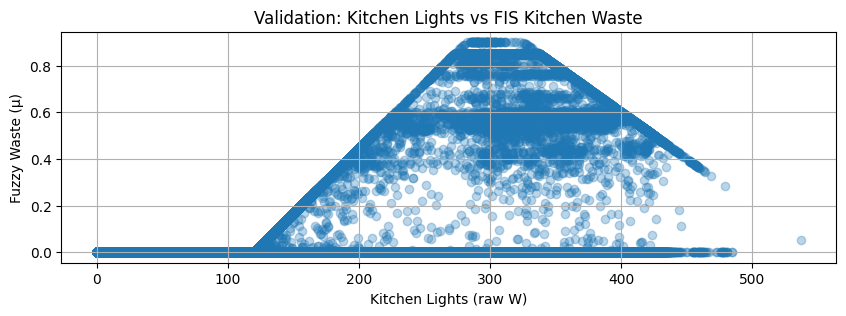

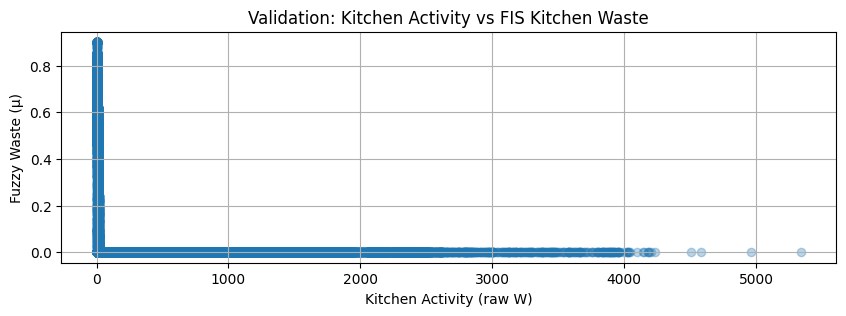

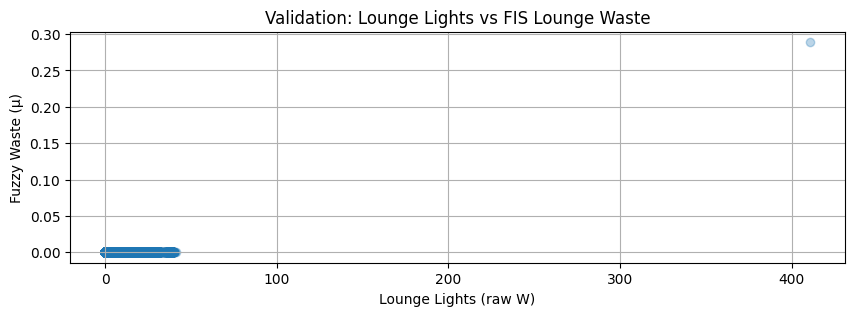

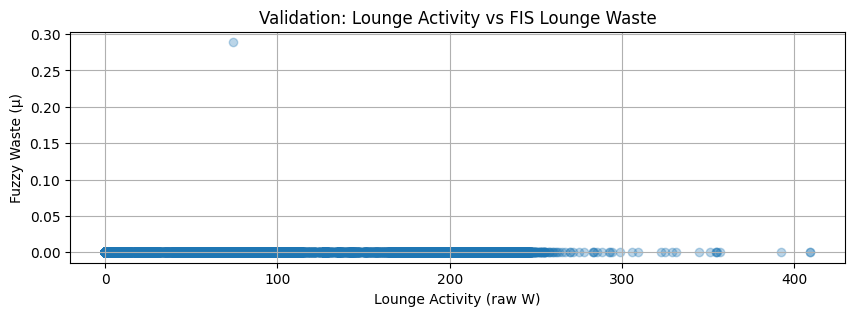

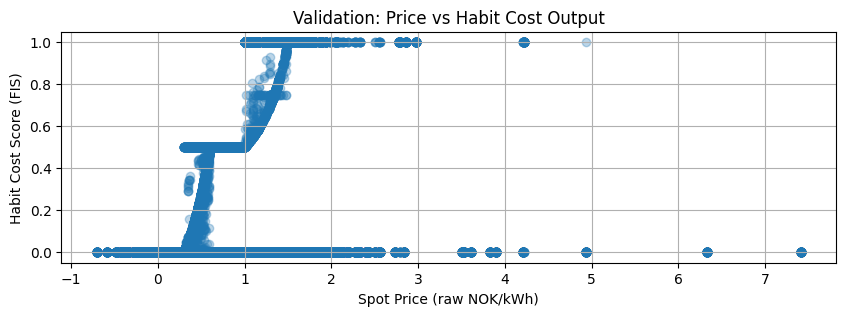

In [ ]:
plots = [
    # --- KITCHEN VALIDATION ---
    ("kitchen_lights_raw", "kitchen_waste_fuzzy",
     "Kitchen Lights (raw W)", "Fuzzy Waste (μ)",
     "Validation: Kitchen Lights vs FIS Kitchen Waste"),

    ("kitchen_activity_raw", "kitchen_waste_fuzzy",
     "Kitchen Activity (raw W)", "Fuzzy Waste (μ)",
     "Validation: Kitchen Activity vs FIS Kitchen Waste"),

    # --- LOUNGE VALIDATION ---
    ("lounge_lights_raw", "lounge_waste_fuzzy",
     "Lounge Lights (raw W)", "Fuzzy Waste (μ)",
     "Validation: Lounge Lights vs FIS Lounge Waste"),

    ("lounge_activity_raw", "lounge_waste_fuzzy",
     "Lounge Activity (raw W)", "Fuzzy Waste (μ)",
     "Validation: Lounge Activity vs FIS Lounge Waste"),

    # --- HABIT COST VALIDATION ---
    ("price_raw", "habit_cost_fuzzy",
     "Spot Price (raw NOK/kWh)", "Habit Cost Score (FIS)",
     "Validation: Price vs Habit Cost Output"),
]

for x, y, xlab, ylab, title in plots:
    plt.figure(figsize=(10,3))
    plt.scatter(validation_df[x], validation_df[y], alpha=0.3)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True)
    plt.show()


1. Kitchen Lights vs FIS Kitchen Waste plot shows how kitchen lighting power relates to the fuzzy kitchen-waste output. Higher light usage during low kitchen activity results in higher waste scores, forming the triangular pattern defined by the FIS rules.

2. Kitchen Activity vs FIS Kitchen Waste validates that kitchen waste is only high when lights are on and activity is low. High activity correctly produces a near-zero waste score, even when activity power spikes.

3. Lounge Lights vs FIS Lounge Waste scatterplot shows that lounge waste increases only when lounge lights are on while lounge activity is low. Most points stay near zero because lounge lights are usually off or low.

4. Lounge Activity vs FIS Lounge Waste confirms that lounge waste only increases when lights are on while lounge activity is low or idle. High activity correctly produces near-zero waste even when activity power varies.

5. Price vs FIS Habit Cost figure shows how the FIS habit-cost score rises when electricity prices are high and household activity is high. The steep increase reflects the fuzzy rule weighting price × usage.

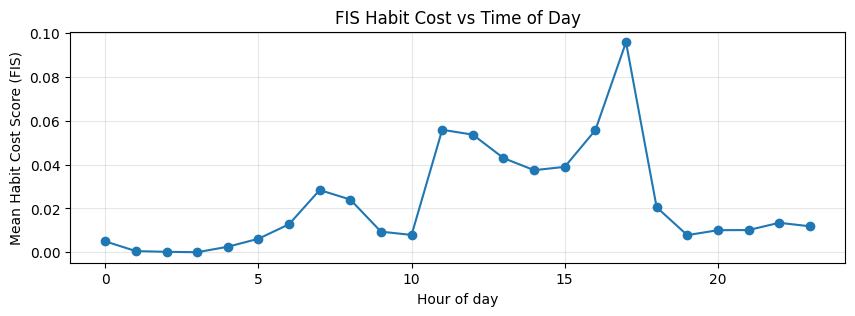

In [ ]:
# Average fuzzy habit cost by hour of day
hourly = validation_df.copy()
hourly["hour"] = fuzzy_data["hour"]
hourly_mean = hourly.groupby("hour")["habit_cost_fuzzy"].mean()

plt.figure(figsize=(10,3))
plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Mean Habit Cost Score (FIS)")
plt.title("FIS Habit Cost vs Time of Day")
plt.grid(True, alpha=0.3)
plt.show()


6. The FIS Habit Cost vs Time of Day plot shows how habit-cost scores vary across the day, with higher values occurring during hours where both electricity prices and household activity tend to peak.

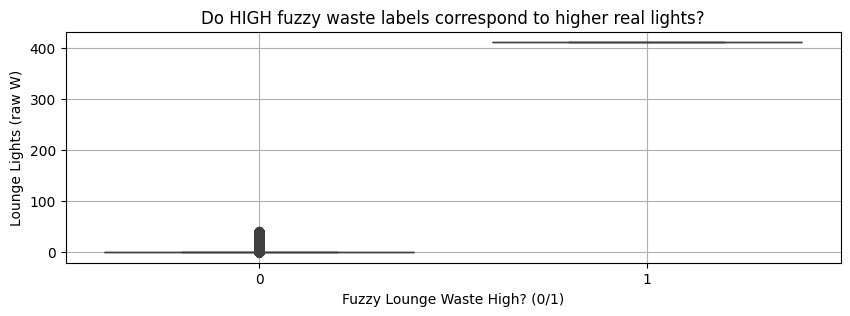

In [ ]:

# 4) Boxplot: do HIGH fuzzy waste labels correspond to higher real lights?

# Use mean as threshold just for illustration
waste_indicator = (validation_df["lounge_waste_fuzzy"] >
              validation_df["lounge_waste_fuzzy"].mean()).astype(int)

plt.figure(figsize=(10,3))
sns.boxplot(x=waste_indicator, y=validation_df['lounge_lights_raw'])
plt.xlabel("Fuzzy Lounge Waste High? (0/1)")
plt.ylabel("Lounge Lights (raw W)")
plt.title("Do HIGH fuzzy waste labels correspond to higher real lights?")
plt.grid(True)
plt.show()



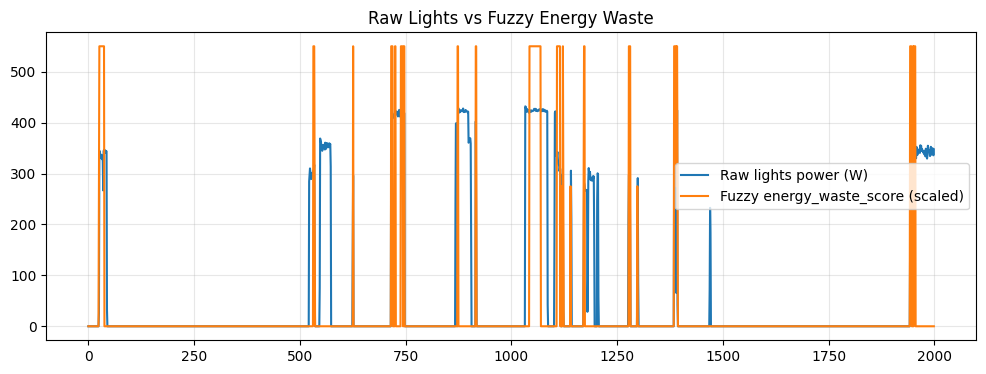

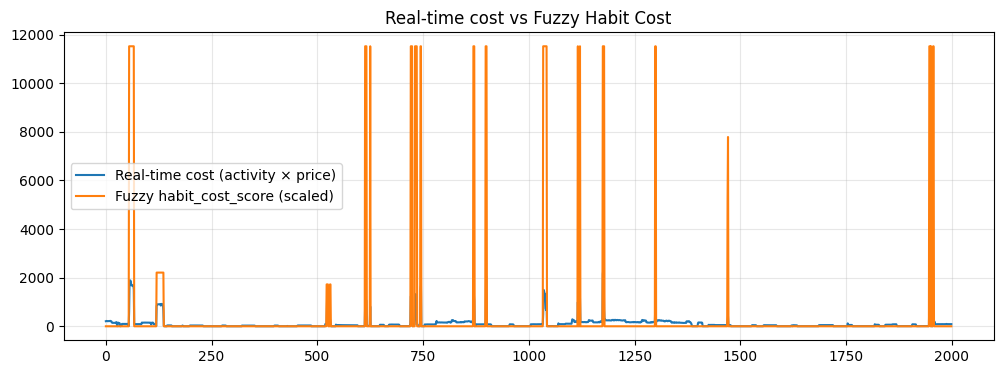

In [ ]:

window = slice(0, 2000)

# Raw lights vs fuzzy energy waste
raw_lights = validation_df["kitchen_lights_raw"] + validation_df["lounge_lights_raw"]
waste_score = validation_df["energy_waste_score"]

plt.figure(figsize=(12,4))
plt.plot(raw_lights.iloc[window].values, label='Raw lights power (W)')
plt.plot(waste_score.iloc[window].values * raw_lights.max(),
         label='Fuzzy energy_waste_score (scaled)')
plt.title('Raw Lights vs Fuzzy Energy Waste')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Raw cost proxy vs fuzzy habit cost
raw_cost_proxy = validation_df["activity_total_raw"] * validation_df["price_raw"]
habit_score = validation_df["habit_cost_fuzzy"]

plt.figure(figsize=(12,4))
plt.plot(raw_cost_proxy.iloc[window].values, label='Real-time cost (activity × price)')
plt.plot(habit_score.iloc[window].values * raw_cost_proxy.max(),
         label='Fuzzy habit_cost_score (scaled)')
plt.title('Real-time cost vs Fuzzy Habit Cost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


1. Raw Lights vs Fuzzy Energy Waste plot shows how spikes in total lighting power align with increases in the fuzzy energy-waste score. The FIS correctly flags periods where lights are on despite low activity by producing high waste peaks.

2. Estimated Real-time cost vs Fuzzy Habit Cost plot compares the raw cost proxy (activity × price) with the FIS habit-cost score. The fuzzy habit-cost output rises sharply during high-price, high-usage periods, confirming that the FIS correctly captures cost-intensive behavior.

In [ ]:

# 6) Simple correlations for reporting (same window, just for numbers in the text)
corr_lights = np.corrcoef(raw_lights.iloc[window], waste_score.iloc[window])[0,1]
corr_cost   = np.corrcoef(raw_cost_proxy.iloc[window], habit_score.iloc[window])[0,1]

print("Correlation raw_lights vs energy_waste_score:", corr_lights)
print("Correlation raw_cost_proxy vs habit_cost_score:", corr_cost)


Correlation raw_lights vs energy_waste_score: 0.5073938021522763
Correlation raw_cost_proxy vs habit_cost_score: 0.8411996681560243


The correlation between raw lighting power and the fuzzy energy waste score was 0.51, indicating a somewhat good correlation. This is to be expected, given that waste detection is affected by activity and time of day, as well as light magnitude.

The correlation between a raw cost proxy (activity × spot price) and the fuzzy habit cost score was 0.84, indicating significant alignment between fuzzy reasoning and cost fluctuations.

These results show that the fuzzy approach accurately captures real-world use patterns while maintaining interpretability and non-linear reasoning beyond straight numerical thresholds.